In [1]:
import json, requests
import pandas as pd
from tqdm import tqdm

In [2]:
# Load the SQuAD 2.0 JSON file
# URL of the SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

# Fetch the content from the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON content into a dictionary
    squad_data = response.json()

In [3]:
# Initialize lists to hold flattened data
data_list = []

# Use tqdm to add a progress bar to the outer loop
for article in tqdm(squad_data['data'], desc='Processing Articles'):
    title = article['title']
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            qid = qa['id']
            is_impossible = qa.get('is_impossible', False)
            answers = qa.get('answers', [])
            if not is_impossible:
                for answer in answers:
                    answer_text = answer['text']
                    answer_start = answer['answer_start']
                    data_list.append({
                        'title': title,
                        'context': context,
                        'question': question,
                        'id': qid,
                        'is_impossible': is_impossible,
                        'answer_text': answer_text,
                        'answer_start': answer_start
                    })
            else:
                # For unanswerable questions, append with empty answer fields
                data_list.append({
                    'title': title,
                    'context': context,
                    'question': question,
                    'id': qid,
                    'is_impossible': is_impossible,
                    'answer_text': None,
                    'answer_start': None
                })

# Convert list of records to a DataFrame
df = pd.DataFrame(data_list)
df.set_index("id", inplace=True)

# Display the DataFrame
print(df.head())

Processing Articles: 100%|██████████| 442/442 [00:00<00:00, 4456.52it/s]

                            title  \
id                                  
56be85543aeaaa14008c9063  Beyoncé   
56be85543aeaaa14008c9065  Beyoncé   
56be85543aeaaa14008c9066  Beyoncé   
56bf6b0f3aeaaa14008c9601  Beyoncé   
56bf6b0f3aeaaa14008c9602  Beyoncé   

                                                                    context  \
id                                                                            
56be85543aeaaa14008c9063  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9065  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9066  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9601  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9602  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   

                                                                   question  \
id                                                                            
56be85543aeaaa14008c9063    

In [4]:
df.sample(5)

,title,context,question,is_impossible,answer_text,answer_start
id,,,,,,
572edf54dfa6aa1500f8d489,The_Blitz,"Within the Luftwaffe, there was a more muted v...",Who believe air power alone would not be decis...,False,Luftwaffe,11.0
5727fc32ff5b5019007d9a14,USB,Sleep-and-charge USB ports can be used to char...,What remain powered even whenever the computer...,False,Sleep-and-charge USB ports,232.0
570c301c6b8089140040fbe9,Federal_Bureau_of_Investigation,"For over 40 years, the FBI crime lab in Quanti...",What did the National Academy of Sciences inde...,False,deeply flawed,584.0
572ac813111d821400f38d68,John_Kerry,In a speech before the Organization of America...,Where did Kerry speak in Nov 2013?,False,the Organization of American States,19.0
5a6a637fa9e0c9001a4e9dd7,Liberal_Party_of_Australia,The Gorton Government increased funding for th...,Who increased funding for corporations?,True,None,NaN


Evaluation on LLM-RAG:

1. Retrieval - RAG retrieved the needed context? <br>
2. Relevance - LLM deciphered the relevant context? <br>
3. Accuracy - LLM answer contains the answer <br>
4. Precision - LLM answer does not contain irrelevant answer <br>







In [5]:
import itertools
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate

import deh.settings as settings
import deh.guardrail as guardrail
from deh.utils import format_context_documents as format_docs
from deh.utils import retriever_with_scores, dedupulicate_contexts
from deh.prompts import (
    qa_eval_prompt_with_context_text,
    LLMEvalResult,
    rag_text_prompts,
    hyde_prompts,
)
import deh

In [6]:
# Set up load balancing between the two instances
nLLM = 8
LLM = [Ollama(
            base_url=settings.OLLAMA_HOST, model=settings.LLM_MODEL, verbose=True
        ) for i in range(nLLM)
      ] 

print(len(LLM))
print(LLM[-1])

# Create a round-robin iterator using itertools.cycle
round_robin_models = itertools.cycle(LLM)

def LLMinvoke(prompt):
    # Get the next model in the round-robin cycle
    selected_model = next(round_robin_models)
    
    # Invoke the selected model with the prompt
    response = selected_model.invoke(prompt)
    return response

Ollama
Params: {'model': 'llama3.1:8b-instruct-q3_K_L', 'format': None, 'options': {'mirostat': None, 'mirostat_eta': None, 'mirostat_tau': None, 'num_ctx': None, 'num_gpu': None, 'num_thread': None, 'num_predict': None, 'repeat_last_n': None, 'repeat_penalty': None, 'temperature': None, 'stop': None, 'tfs_z': None, 'top_k': None, 'top_p': None}, 'system': None, 'template': None, 'keep_alive': None, 'raw': None}


/tmp/ipykernel_23/1481578329.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  LLM = [Ollama(


In [7]:
row = 0
q = df.iloc[row]["question"]
c = df.iloc[row]["context"]
gt = df.iloc[row]["answer_text"]

# Initial LLM generation prompt:
qa_prompt = PromptTemplate(
    template=rag_text_prompts[0], input_variables=["question", "context"]
)

chain = qa_prompt | LLMinvoke
llmans = chain.invoke({"question": q, "context": c})

print(llmans)

Beyoncé started becoming popular in the late 1990s as lead singer of R&B girl-group Destiny's Child. This was also when her group became one of the world's best-selling girl groups of all time. Her solo debut album, Dangerously in Love (2003), further established her popularity worldwide.


In [8]:
print(q)
print(c)
print(gt)
print(chain)

When did Beyonce start becoming popular?
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
in the late 1990s
first=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="\n    You are an assistant for question-answering tasks.\n    Use the following pieces of retrieved context to answer the question.\n   

In [9]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio

nest_asyncio.apply()

# Assuming chain.invoke is an asynchronous function
async def invoke_chain(chain, q, c, semaphore, pbar):
    async with semaphore:
        pbar.update(1)
        return await chain.ainvoke({"question": q, "context": c})

async def main(df = None, LLM = None, n=50, clim=8):
    # input validation 
    if df.empty:
        raise ValueError("The DataFrame is empty")
    assert (LLM != None)
    
    # Initial LLM generation prompt:
    qa_prompt = PromptTemplate(
        template=rag_text_prompts[0], input_variables=["question", "context"]
    )
    chain = qa_prompt | LLMinvoke

    # Create a semaphore with a limit on concurrent tasks
    semaphore = asyncio.Semaphore(clim)

    # Create a tqdm progress bar
    samdf = df.sample(n, random_state=42)
    with tqdm(total=n, desc="Processing") as pbar:
        tasks = [invoke_chain(chain, row['question'], row['context'], semaphore, pbar) for _, row in samdf.iterrows()]
        results = await asyncio.gather(*tasks)

    return results

In [10]:
# Run the main function
results = await main(df, LLM, 1000, 32)

Processing: 100%|██████████| 1000/1000 [07:46<00:00,  2.14it/s]


In [11]:
# Print the results
for i in range(10): 
    print(str(i) + " : " + results[i])

0 : The global recession that followed the financial crisis of 2007 ended in 2012. This was a period of economic downturn that lasted for about five years, affecting many countries worldwide. It was linked to the European sovereign-debt crisis and other economic challenges.
1 : Amnesia was a popular club in Ibiza that started playing dance and house music, featuring DJ Alfredo. It played a mix of rock, pop, disco, and house, which began to influence the British scene. This sound was later brought to UK clubs by DJs such as Trevor Fung, Paul Oakenfold, and Danny Rampling.
2 : Martin Luther honored Mary as the Mother of God in the 16th century. This was around the same time that Calvin and Huldrych Zwingli showed similar reverence for Mary. Their actions were later distinguished from Catholic veneration by the Protestant movement.
3 : Himachal experiences a diverse climate due to its varying elevation, ranging from hot and humid tropical to cold and glacial conditions. The state has thre

In [12]:
# Run the main function
results = await main(df, LLM, 1000, 32)

Processing: 100%|██████████| 1000/1000 [07:50<00:00,  2.12it/s]


In [14]:
# Print the results
for i in range(10): 
    print(str(i) + " : " + results[i])

0 : The global recession that followed the financial crisis of 2007 ended in 2012. This is indicated by the text as part of the global recession and European sovereign-debt crisis. It lasted for approximately 5 years.
1 : Amnesia was a popular club in Ibiza that started playing dance and house music. It was known for its distinct Balearic mix of house by the mid-1980s. DJ Alfredo played at Amnesia, contributing to the club's influence on the British scene.
2 : Martin Luther honored Mary as the Mother of God in the 16th century, but less than Calvin and Zwingli. The first Protestants initially respected Mary, but later criticized Catholics for venerating her. This led to a decline in Protestant interest in Mary by the Age of the Enlightenment.
3 : Himachal's climate varies greatly due to its diverse elevation, ranging from hot and subhumid tropical to cold, alpine, and glacial conditions. The state experiences three seasons: summer, winter, and rainy season, with summer lasting from mid

In [15]:
ans_len = df["answer_text"].str.split().str.len()
print(ans_len.mean())
print(ans_len.std())

3.1627716796627543
3.3909471172900374


In [18]:
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 644.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 719.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 623.2 kB/s eta 0:00:00a 0:00:01


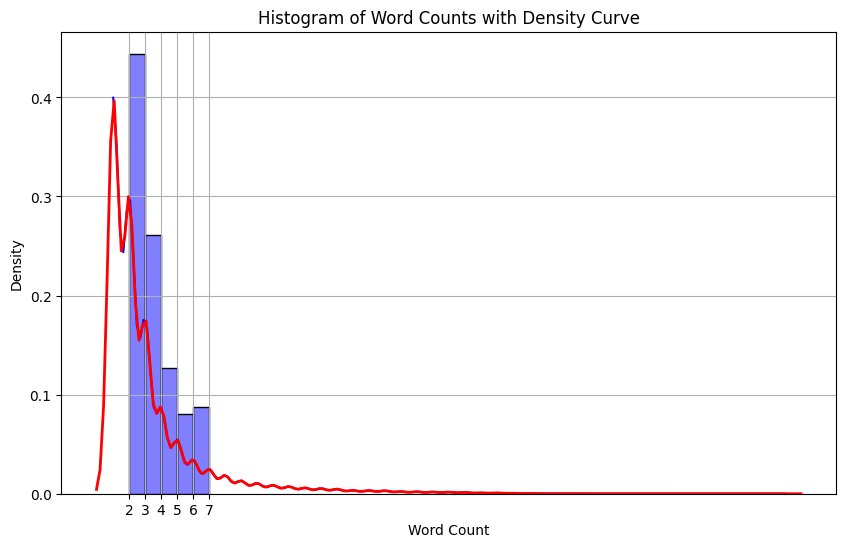

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Step 3: Create the histogram with density curve
sns.histplot(ans_len, bins=range(2, 8), kde=True, stat='density', color='blue', edgecolor='black')

# Step 4: Add density curve (optional, as kde=True already adds it)
sns.kdeplot(ans_len, color='red', linewidth=2)

# Step 5: Add labels and title
plt.title('Histogram of Word Counts with Density Curve')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.xticks(range(2, 8))
plt.grid(True)

# Show the plot
plt.show()

In [21]:
print((ans_len > 10).sum())

3915


In [27]:
df[ans_len > 10]["answer_text"].sample(50).tolist()

['successful for the Prussian-led forces on the continent, in contrast to disappointing British campaigns in North America.',
 'the measurement of light sensitivity of the entire digital camera system and not of individual components',
 'neo-Attic Imperial Roman copies of the late 1st or early 2nd century',
 'host both transient and deployed USN and USAF aircraft, as well as transitioning or deployed Royal Air Force and Canadian Forces aircraft.',
 'American University of Armenia and the QSI International School of Yerevan',
 'the 2009 World Badminton Championships and the 2009 IBSF World Snooker Championship',
 'Short-toed eagles (Circaetus gallicus), tawny eagles (Aquila rapax), spotted eagles (Aquila clanga)',
 'word γραῖα graia "old woman" comes from the PIE root *ǵerh2-/*ǵreh2-, "to grow old" via Proto-Greek *gera-/grau-iu',
 'first recorded on audio tape, which could then be processed and/or edited, and then dubbed on to the master disc',
 'the sole objective of getting John XXII